In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import authentic_performance as ap
from scipy.stats import uniform, norm
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import torch_geometric.utils as utils

c:\Users\leroy\anaconda3\envs\mma2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def power_law(x, a=1):
    return (1/x)**a

In [313]:
N = 100
P = 10/N
DISTRIBUTION = uniform

FRAUD = True
FRAUD_PROBABILITY = 0.7
FRAUDSTER_INDEX = round(N/2)  # or round(N/2)
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()
FRAUD_SCHEME = "strength"  # "strength" or None

STRENGTH_SCHEME = False
ITERATIONS = 10000  # strength scheme iterations
DECREASING_FUNCTION = lambda x : power_law(x, 3)  # decreasing function for strength scheme

G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=FRAUD_PROBABILITY,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)

nx.set_node_attributes(G, {k:{"delta_degrees_in_out":v} for k, v in dict(pd.Series(dict(G.in_degree())) - pd.Series(dict(G.out_degree()))).items()})
nx.set_node_attributes(G, {k:{"pr":v} for k,v in nx.pagerank(G).items()})
nx.write_gexf(G, "gephi_viz/synthetic.gexf")

# 1. Random network, dumb frauder

In [314]:
N = 100
P = 10/N
DISTRIBUTION = uniform

FRAUD = True
FRAUD_PROBABILITY = 0.7
FRAUDSTER_INDEX = round(N/2)  # or round(N/2)
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()
FRAUD_SCHEME = None  # "strength" or None

STRENGTH_SCHEME = False
ITERATIONS = 10000  # strength scheme iterations
DECREASING_FUNCTION = lambda x : power_law(x, 3)  # decreasing function for strength scheme

## 1.1 Delta degrees ranking

In [247]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series_delta_degrees = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        l.append(pd.Series(dict(pd.Series(dict(G.in_degree())) - pd.Series(dict(G.out_degree())))).sort_index())
    list_series_delta_degrees.append(pd.concat(l, axis=1).mean(axis=1).sort_index())

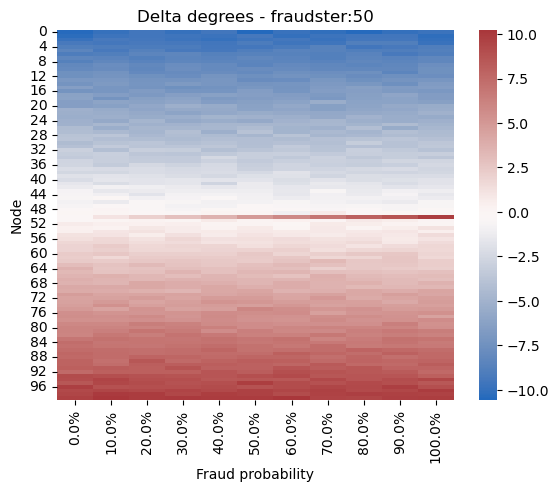

In [269]:
ax = sns.heatmap(pd.concat(list_series_delta_degrees, axis=1).values,
            cmap=sns.color_palette("vlag", as_cmap=True),
            xticklabels=[f"{100*x}%" for x in list_fraud_probabilities]).set(xlabel='Fraud probability', ylabel='Node', title=f"Delta degrees - fraudster:{FRAUDSTER_INDEX}");

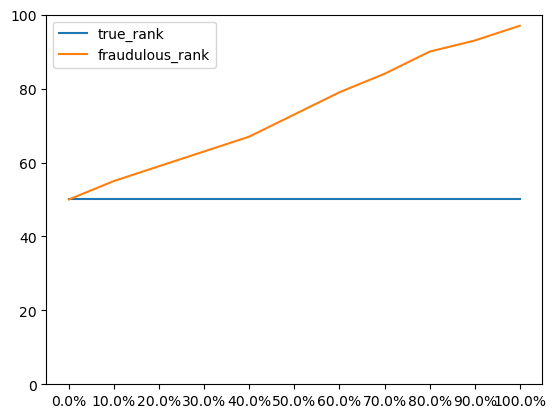

In [249]:
plt.plot([FRAUDSTER_INDEX for _ in list_series_delta_degrees], label="true_rank")
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series_delta_degrees], label="fraudulous_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

There is a linear relationship between the proportion of fraudulous links and the expected improvement of the rank which comes from the fact that the delta degree function is linear wrt the proportion of fraudulous links. Clearly the delta degree rating function is sensible to this kind of fraud.

## 1.2 $f_{\alpha,t}$

In [271]:
G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)

In [ ]:
def ranking_winLossDraw(w, l, d, alpha=0, offset=0):
    """simple ranking based on win/loss/draw informations.

    Args:
        w (int): number of wins
        l (int): number of losses
        d (int): number of draws
        alpha (int, optional): penalization term for the losses in [-1, +inf]. Close to -1 : . Defaults to 0.
        offset (int, optional): offset to avoid fighters with few matches to be extremely well rated. Defaults to 0.

    Returns:
        _type_: ranking between 0 and 1
    """
    return (w - alpha*l +.5*d - 0.5*alpha*d)/(w+l+d+offset)

In [ ]:
def convert_graphToDataFrame(G):
    df = pd.DataFrame([x[1] for x in list(G.nodes(data=True))])
    s = pd.Series([x[0] for x in list(G.nodes(data=True))], name="node")
    df = pd.concat([df, s,
            pd.Series(dict(G.in_degree()), name="wins"),
            pd.Series(dict(G.out_degree()), name="losses")],
            axis=1)
    df["draws"] = 0
    return df

def generate_trainingData(n=10):
    l_df = []
    for _ in range(n):
        G = ap.generate_network(N,
                        P,
                        distribution=DISTRIBUTION,
                        fraud=False,
                        fraudster_index=FRAUDSTER_INDEX,
                        fraudster_strength=FRAUDSTER_STRENGTH,
                        fraud_probability=proba,
                        strength_scheme=STRENGTH_SCHEME,
                        iterations=ITERATIONS,
                        decreasing_function=DECREASING_FUNCTION,
                        fraud_scheme=FRAUD_SCHEME)
        df = convert_graphToDataFrame(G)
        l_df.append(df)
    df = pd.concat(l_df)
    X_train, X_test, y_train, y_test = train_test_split(df[["wins","losses","draws"]].values, df["strength"].values, test_size=0.33)
    return torch.tensor(X_train, dtype=torch.float), torch.tensor(X_test, dtype=torch.float), torch.tensor(y_train, dtype=torch.float), torch.tensor(y_test, dtype=torch.float)

In [ ]:
class WinLossDraw(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor([1.]))
        self.t = torch.nn.Parameter(torch.tensor([1.]))

    def forward(self, x):
        w, l, d = x[:,0], x[:,1], x[:,2]
        h = (w - self.alpha*l +.5*d - 0.5*self.alpha*d)/(w+l+d+self.t)
        y = torch.nn.Sigmoid()(h)
        return y

In [ ]:
X_train, X_test, y_train, y_test = generate_trainingData(n=1000)

model = WinLossDraw()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

(array([4322., 3494., 3099., 2833., 3612., 2010., 2847., 3581., 2993.,
        4209.]),
 array([0.27797163, 0.32245326, 0.3669349 , 0.41141653, 0.45589817,
        0.5003798 , 0.54486144, 0.5893431 , 0.6338247 , 0.67830634,
        0.722788  ], dtype=float32),
 <BarContainer object of 10 artists>)

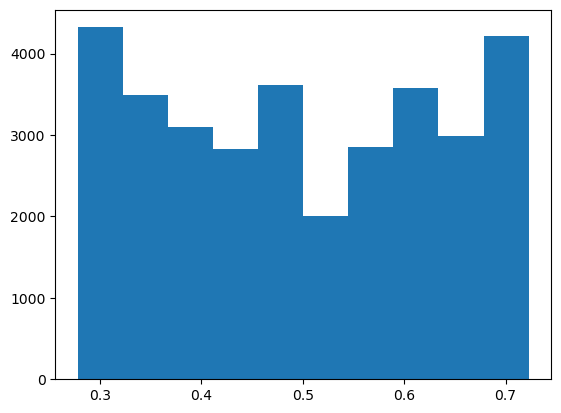

In [ ]:
# before training
output = model(X_test)
plt.hist(output.detach().numpy())

In [ ]:
l_losses = []
l_param = []
for i in range(5000):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    l_losses.append(loss.item())
    l_param.append((model.alpha.item(), model.t.item()))

Text(0.5, 1.0, 'Offset t')

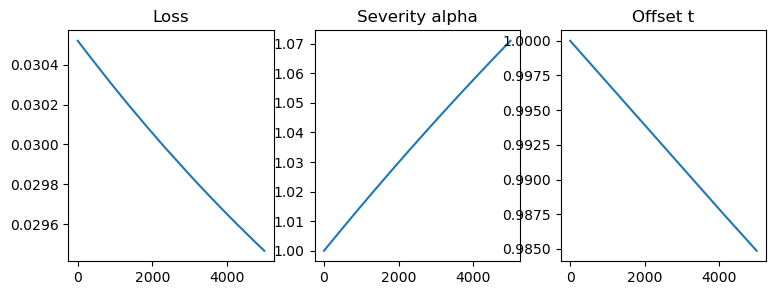

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot(l_losses)
ax[0].set_title("Loss")
ax[1].plot([x[0] for x in l_param])
ax[2].plot([x[1] for x in l_param])
ax[1].set_title("Severity alpha")
ax[2].set_title("Offset t")

(array([4322., 3494., 3298., 2634., 3591., 2427., 2856., 3180., 2989.,
        4209.]),
 array([0.264444  , 0.31029052, 0.35613704, 0.40198353, 0.44783005,
        0.49367657, 0.53952307, 0.5853696 , 0.6312161 , 0.67706263,
        0.72290915], dtype=float32),
 <BarContainer object of 10 artists>)

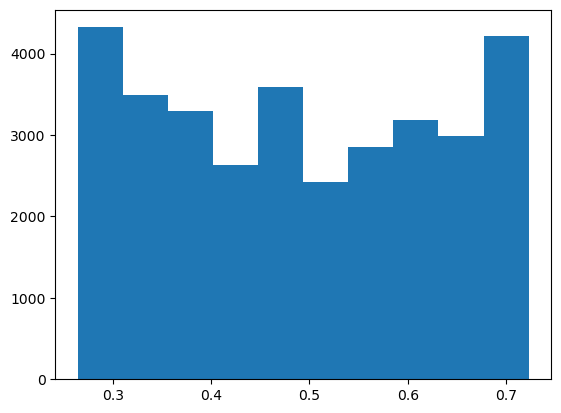

In [ ]:
# after training
output = model(X_test)
plt.hist(output.detach().numpy())

In [ ]:
print(f"Mean squared error on test set: {((output-y_test)**2).sum()/len(y_test)}")

Mean squared error on test set: 0.029292380437254906


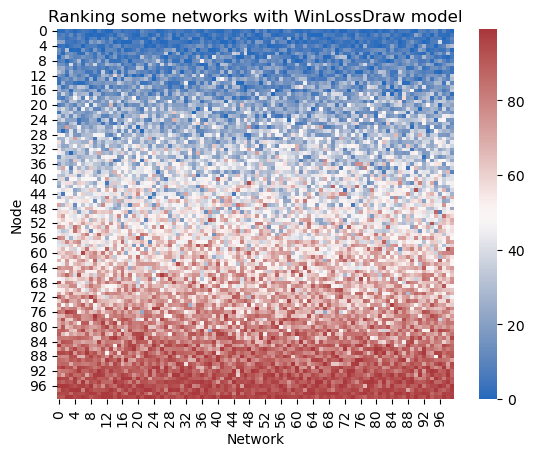

In [ ]:
l_series = []
for _ in range(100):
    G = ap.generate_network(N,
                            P,
                            distribution=DISTRIBUTION,
                            fraud=False,
                            fraudster_index=FRAUDSTER_INDEX,
                            fraudster_strength=FRAUDSTER_STRENGTH,
                            fraud_probability=proba,
                            strength_scheme=STRENGTH_SCHEME,
                            iterations=ITERATIONS,
                            decreasing_function=DECREASING_FUNCTION,
                            fraud_scheme=FRAUD_SCHEME)

    df = convert_graphToDataFrame(G)
    df["pred_strength"] = model(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
    l_series.append(df["pred_strength"].rank() -1)

ax = sns.heatmap(pd.concat(l_series, axis=1).values,
            cmap=sns.color_palette("vlag", as_cmap=True)).set(xlabel='Network', ylabel='Node', title = "Ranking some networks with WinLossDraw model");

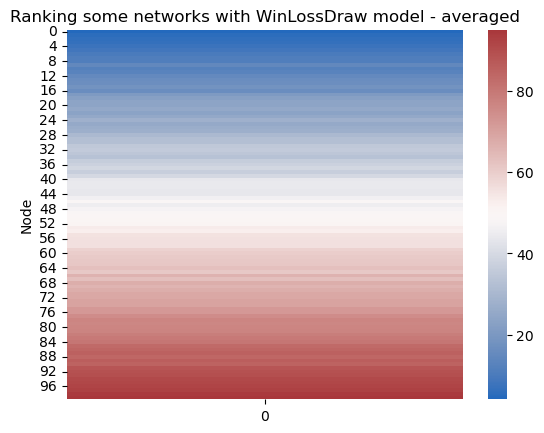

In [ ]:
ax = sns.heatmap(pd.concat(l_series, axis=1).mean(axis=1).values.reshape(-1,1),
            cmap=sns.color_palette("vlag", as_cmap=True)).set(ylabel='Node', title = "Ranking some networks with WinLossDraw model - averaged");

We can see that the WinLossDraw model performs very good on average.

In [ ]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        
        df = convert_graphToDataFrame(G)
        df["pred_strength"] = model(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        l.append(df["pred_strength"].rank() -1)
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))

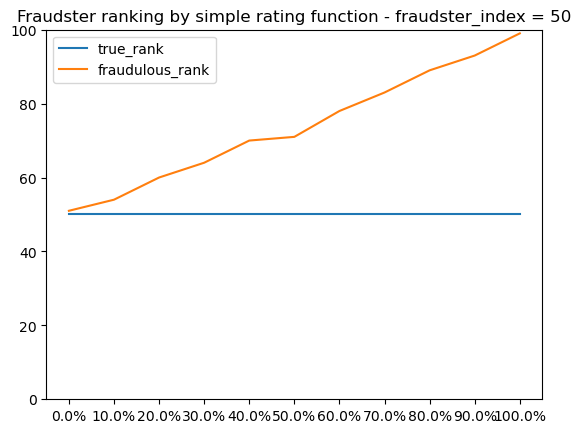

In [ ]:
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_rank")
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series], label="fraudulous_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.title(f"Fraudster ranking by simple rating function - fraudster_index = {FRAUDSTER_INDEX}")
plt.legend()

We can see that the function simple rating is fooled by the fraudster. It appears that the pattern is also linear.

## 1.3 Siamese MLP rater

## 1.4 PageRank

## 1.5 Credible PageRank

## 1.6 GNN

### GNN graph classification
Task : predict if there is a fraud in the network (random network, dumb fraudster) from example with and without a fraudster in the network \
Result : simple GNN is not able to detect fraud (0.5 accuracy)

In [ ]:
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx

In [ ]:
data_list = []
y = []
for _ in range(100):
    G = ap.generate_network(N,
                        P,
                        distribution=DISTRIBUTION,
                        fraud=True,
                        fraudster_index=FRAUDSTER_INDEX,
                        fraudster_strength=FRAUDSTER_STRENGTH,
                        fraud_probability=FRAUD_PROBABILITY,
                        strength_scheme=STRENGTH_SCHEME,
                        iterations=ITERATIONS,
                        decreasing_function=DECREASING_FUNCTION,
                        fraud_scheme=FRAUD_SCHEME)
    H = nx.DiGraph()
    H.add_nodes_from(sorted(G.nodes(data=True)))
    H.add_edges_from(G.edges(data=True))
    pyg_graph = from_networkx(H)
    pyg_graph.y = torch.tensor(True).float()
    pyg_graph.x = torch.stack((utils.degree(pyg_graph.edge_index[1], pyg_graph.num_nodes), utils.degree(pyg_graph.edge_index[1], pyg_graph.num_nodes)), dim=1)
    data_list.append(pyg_graph)
    
    G = ap.generate_network(N,
                        P,
                        distribution=DISTRIBUTION,
                        fraud=False,
                        fraudster_index=FRAUDSTER_INDEX,
                        fraudster_strength=FRAUDSTER_STRENGTH,
                        fraud_probability=FRAUD_PROBABILITY,
                        strength_scheme=STRENGTH_SCHEME,
                        iterations=ITERATIONS,
                        decreasing_function=DECREASING_FUNCTION,
                        fraud_scheme=FRAUD_SCHEME)
    H = nx.DiGraph()
    H.add_nodes_from(sorted(G.nodes(data=True)))
    H.add_edges_from(G.edges(data=True))
    pyg_graph = from_networkx(H)
    pyg_graph.y = torch.tensor(False).float()
    pyg_graph.x = torch.stack((utils.degree(pyg_graph.edge_index[1], pyg_graph.num_nodes), utils.degree(pyg_graph.edge_index[1], pyg_graph.num_nodes)), dim=1)
    data_list.append(pyg_graph)
    
train_dataset, test_dataset = data_list[:int(len(data_list)*0.8)], data_list[int(len(data_list)*0.8):]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 160
Number of test graphs: 40


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 9785], strength=[2000], fraud=[2000], fraudulous=[9785], num_nodes=2000, y=[20], x=[2000, 2], batch=[2000], ptr=[21])

Step 2:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 9890], strength=[2000], fraud=[2000], fraudulous=[9890], num_nodes=2000, y=[20], x=[2000, 2], batch=[2000], ptr=[21])

Step 3:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 9783], strength=[2000], fraud=[2000], fraudulous=[9783], num_nodes=2000, y=[20], x=[2000, 2], batch=[2000], ptr=[21])

Step 4:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 9903], strength=[2000], fraud=[2000], fraudulous=[9903], num_nodes=2000, y=[20], x=[2000, 2], batch=[2000], ptr=[21])

Step 5:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 9908], strength=[2000], fraud=[2000], fraudulous=[9908], num_nodes=2000, y=[20], x=[2000, 2], batch=[2000], ptr=[21])

Step 6:
Number of graphs in th

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, input_channels = 2):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(input_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [ ]:
model = GCN(input_channels=2, hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

Epoch: 000, Train Acc: 0.4875, Test Acc: 0.5250
Epoch: 001, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 002, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 003, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 004, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 005, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 006, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 007, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 008, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 009, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 010, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 011, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 012, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 013, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 014, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 015, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 016, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 017, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 018, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 019, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 020, Train Acc: 0.5000, Test Acc:

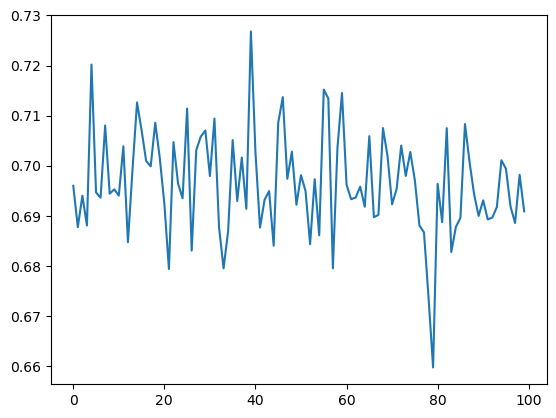

In [ ]:
def train():
    model.train()
    for batch in train_loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()

def test(loader):
    model.eval()
    correct = 0
    for batch in loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == batch.y).sum())
    return correct / len(loader.dataset)

l_losses = []
for epoch in range(100):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    l_losses.append(loss)
plt.plot(l_losses)

### GNN node classification

# 2. Random Network, malicious fraudster

This time the fraudster selects opponents that are weaker but tend to match his strength level.

# 3. Strength-scheme Network, dumb fraudster

Strength scheme means the network is rewired to simulate a matchmaking process that tend to match nodes with comparable strength. The interpolation is continuous between a random network and strength-schemes.

# 4. Strength-scheme, malicious fraudster

## Experiment 1
Fraudster is set to be at median strength ie half on nodes have an inferior strength and half of nodes have a superior one. The fraudster is allowed to pick a proportion of his opponents that he knows to be weaker.

### Fraudster vs PageRank ratings

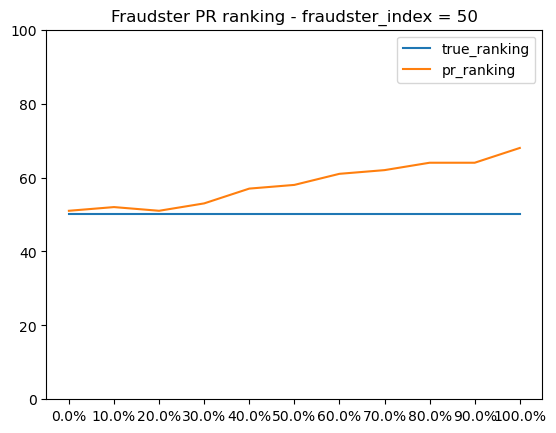

In [8]:
N = 100
DISTRIBUTION = uniform
P = 10/N
FRAUDSTER_INDEX = round(N/2)
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()

list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series_pr = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(n=N, p=P, distribution=DISTRIBUTION, fraudster_index=FRAUDSTER_INDEX, fraudster_strength=FRAUDSTER_STRENGTH,
                                fraud_probability=proba)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    list_series_pr.append(pd.concat(l, axis=1).mean(axis=1).sort_index())

plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series_pr], label="true_ranking")
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series_pr], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

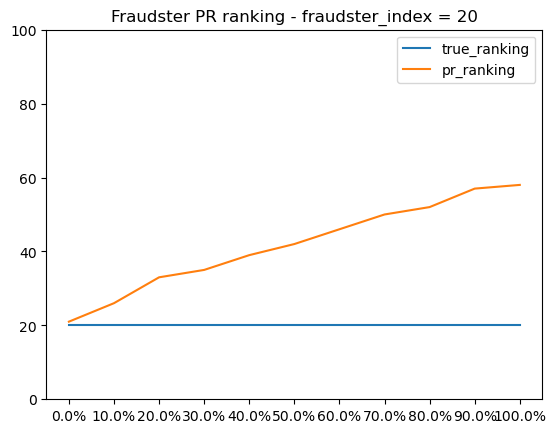

In [9]:
N = 100
DISTRIBUTION = uniform
P = 10/N
FRAUDSTER_INDEX = 20
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()

list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series_pr = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(n=N, p=P, distribution=DISTRIBUTION, fraudster_index=FRAUDSTER_INDEX, fraudster_strength=FRAUDSTER_STRENGTH,
                                fraud_probability=proba)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    list_series_pr.append(pd.concat(l, axis=1).mean(axis=1).sort_index())

plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series_pr], label="true_ranking")
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series_pr], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

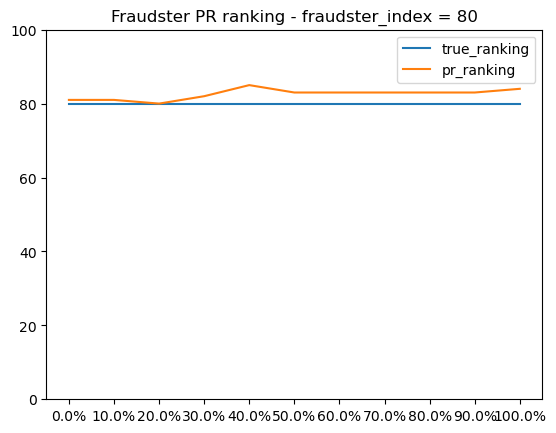

In [10]:
N = 100
DISTRIBUTION = uniform
P = 10/N
FRAUDSTER_INDEX = 80
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()

list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series_pr = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(n=N, p=P, distribution=DISTRIBUTION, fraudster_index=FRAUDSTER_INDEX, fraudster_strength=FRAUDSTER_STRENGTH,
                                fraud_probability=proba)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    list_series_pr.append(pd.concat(l, axis=1).mean(axis=1).sort_index())

plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series_pr], label="true_ranking")
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series_pr], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

PageRank is not fooled as much as the delta degree rating function. However, we can remark that the fraud is bigger when the fraudster's true ranking is low. This can be explained by the fact that selecting opponents that are a lot weaker does not lift a PR much (ie the bigger the difference, the lower the rank increase).

# <>

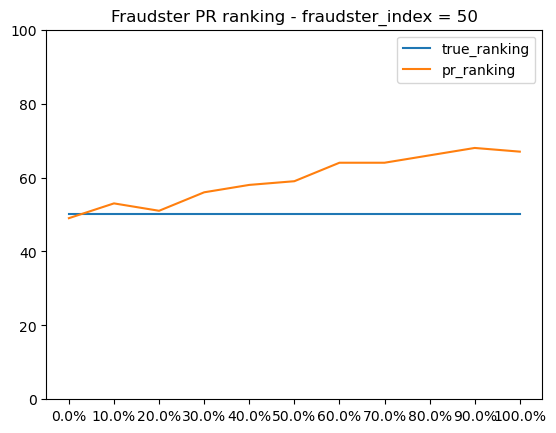

In [315]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))
    
plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_ranking")
plt.plot([(list_series[i].rank()-1)[FRAUDSTER_INDEX] for i in range(len(list_series))], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

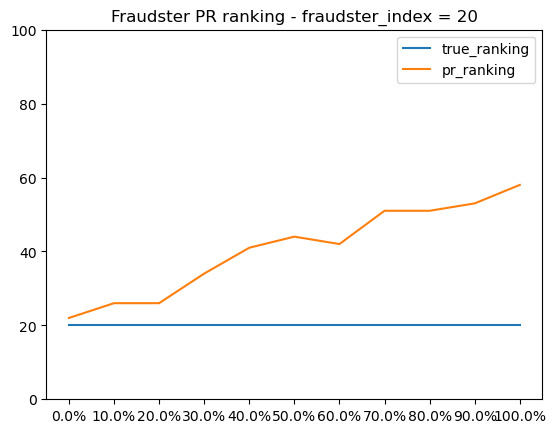

In [308]:
FRAUDSTER_INDEX = 20
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))
    
plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_ranking")
plt.plot([(list_series[i].rank()-1)[FRAUDSTER_INDEX] for i in range(len(list_series))], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

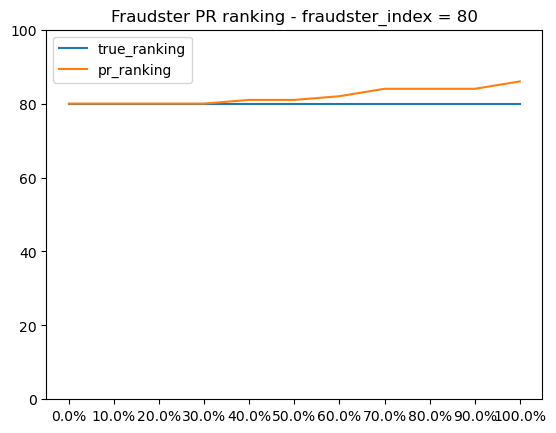

In [309]:
FRAUDSTER_INDEX = 80
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))
    
plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_ranking")
plt.plot([(list_series[i].rank()-1)[FRAUDSTER_INDEX] for i in range(len(list_series))], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

We can see that PageRank is fooled by the fraudster. However the lowest its true rating is, the bigger the rank improvement. That can be because the fraudster is dumb ie it selects any weaker opponent.

In [317]:
def compute_judgesCredibility(G, list_fighters, ego=0., credibility_damping_factor=0.85):
    """Compute the credibility values for all nodes in the network

    Args:
        G (nx.Digraph): network of contacts
        list_fighters (list): nodes to rank
        ego (float, optional): hyperparameter that determines the balance between the fighter's own importance and their judge's importance. Defaults to 0..
    """
    l = []
    for fighter in list_fighters:
        G_fighter = G.copy().to_undirected()
        G_fighter.remove_nodes_from([x for x in list_fighters if x != fighter])
        d = nx.pagerank(G_fighter, personalization={fighter:1}, alpha=credibility_damping_factor, max_iter=10000)
        d.pop(fighter)
        s = pd.Series(d, name=fighter)
        l.append(s)
    df = pd.concat(l, axis=1)

# compute a hadamard product to have an aggregated credibility by node in the graph
    df["credibility"] = df.product(axis=1)
    df["credibility"] = df["credibility"]/(df["credibility"].max())

# add row for each fight in list_fighters since they were missing
    max_credibility = df["credibility"].max()
    for fighter in list_fighters:
        row = {fighter:df[fighter].max()*ego, "credibility":max_credibility*ego}
        for opponent in [x for x in list_fighters if x != fighter]:
            row[opponent] = 0
        df.loc[fighter] = row
    return df

# add nodes attributes to original G : global and marginal credibilities
def add_credibilityToNetwork(df, G):
    G_res = G.copy()
    for col in df.columns:
        d = dict(df[col])
        nx.set_node_attributes(G_res, {k:{col:v} for k,v in d.items()})
    return G_res

def get_relativeStrength(G, list_fighters, damping_factor=0.85):
    pr = nx.pagerank(G, personalization=nx.get_node_attributes(G, "credibility"), alpha=damping_factor, max_iter=10000)
    return pd.Series(pr).loc[list_fighters]

def compute_relativeStrength(G, list_fighters, ego=0.):
    """Compute the strength of nodes in list_fighters

    Args:
        G (nx.Digraph): network of contacts
        list_fighters (list): nodes to rank
        ego (float, optional): hyperparameter that determines the balance between the fighter's own importance and their judge's importance. Defaults to 0..
    """
    df = compute_judgesCredibility(G, list_fighters, ego)
    G = add_credibilityToNetwork(df, G)
    return get_relativeStrength(G, list_fighters), G

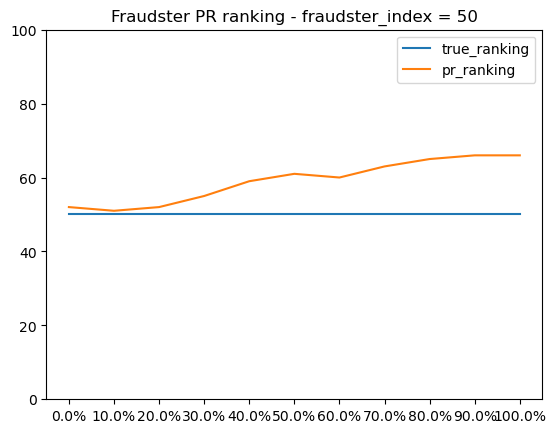

In [316]:
N = 100
P = 10/N
DISTRIBUTION = uniform

FRAUD = True
FRAUD_PROBABILITY = 0.7
FRAUDSTER_INDEX = round(N/2)  # or round(N/2)
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()
FRAUD_SCHEME = None  # "strength" or None

STRENGTH_SCHEME = False
ITERATIONS = 10000  # strength scheme iterations
DECREASING_FUNCTION = lambda x : power_law(x, 3)  # decreasing function for strength scheme

list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))
    
plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_ranking")
plt.plot([(list_series[i].rank()-1)[FRAUDSTER_INDEX] for i in range(len(list_series))], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

In [445]:
FRAUD_PROBABILITY = 0.9
FRAUDSTER_INDEX = 20

G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=FRAUD_PROBABILITY,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)

s = pd.Series(nx.pagerank(G, alpha=0.85)).sort_index()

In [446]:
(s.rank()-1)[20]

64.0

In [447]:
def get_closestRankedNodes(idx, N, k):
    if k%2 != 0:
        raise ValueError("k must be even")
    if idx - k/2 < 0:
        return list(range(0,idx)) + list(range(idx+1,idx + int(k/2) + 1 + abs(idx - int(k/2))))
    if idx + k/2 > N-1 :
        return list(range(idx - int(k/2)- abs(idx + int(k/2) - N + 1),idx)) + list(range(idx+1,N))
    else:
        return list(range(idx - int(k/2),idx)) + list(range(idx+1,idx + int(k/2) + 1))
    
neighborhood = pd.Series(range(N)).apply(lambda x : get_closestRankedNodes(x, N, 4))
neighborhood.head()

0    [1, 2, 3, 4]
1    [0, 2, 3, 4]
2    [0, 1, 3, 4]
3    [1, 2, 4, 5]
4    [2, 3, 5, 6]
dtype: object

In [448]:
ranking = np.array(list((s.rank()-1).sort_values().index))
ranking

array([ 0,  1,  2,  3,  4,  5, 22,  7,  9, 10, 11, 13, 16, 12,  8, 18, 34,
       14, 21,  6, 36, 15, 17, 37, 28, 25, 23, 32, 24, 33, 59, 45, 69, 40,
       43, 19, 38, 30, 26, 35, 48, 41, 29, 42, 57, 31, 44, 47, 46, 27, 68,
       49, 65, 62, 51, 66, 50, 53, 55, 56, 64, 39, 52, 72, 20, 60, 61, 76,
       79, 82, 58, 74, 98, 86, 81, 84, 73, 63, 54, 83, 70, 71, 77, 78, 89,
       94, 67, 75, 85, 87, 88, 92, 90, 80, 91, 93, 97, 95, 96, 99])

In [453]:
compute_relativeStrength(G,[96, 99],ego=0.)

(96    0.083541
 99    0.082272
 dtype: float64,
 <networkx.classes.digraph.DiGraph at 0x1e8fa9d6860>)

In [449]:
l_cpr = []
for i, node in enumerate(ranking):
    neighbors = ranking[neighborhood[i]]
    l = []
    for neighbor in neighbors:
        cpr_node, cpr_neighbor = compute_relativeStrength(G,[node, neighbor],ego=0.)[0].values
        l.append(cpr_neighbor - cpr_node)
    l_cpr.append(l)

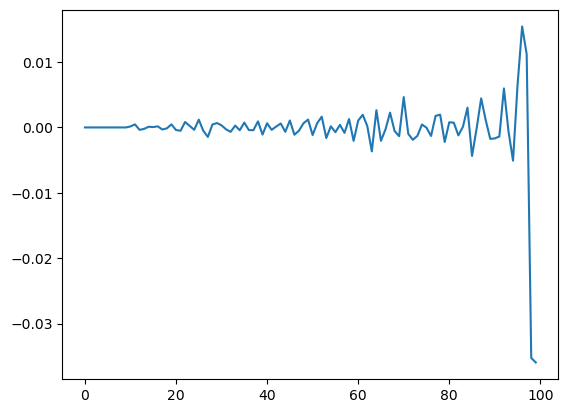

In [450]:
plt.plot(np.array(l_cpr).mean(axis=1))

In [350]:
compute_relativeStrength(G, [50, 64], ego=0.)

(50    0.009058
 64    0.011656
 dtype: float64,
 <networkx.classes.digraph.DiGraph at 0x1e889f26560>)